In [ ]:
# %pip install pandas scikit-learn matplotlib numpy
# %pip install tensorflow[and-cuda]
# %pip install tensorflow

  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pillow-11.3.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 6.1 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 4.1 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 4.5 MB/s  0:00:01 eta 0:00:01
Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.5 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.0 MB/s  0:00:00 eta 0:00:01
Using cached pillow-11.3.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (6.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 5.1 MB/s  0:00:07m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15/15 [matplotlib]5 [matplotlib]n]
Not

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import sklearn
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
from random import shuffle

from model_creation import create_cnn_lstm_model, create_cnn_gru_model


2025-09-15 09:58:09.197455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data_full = pd.read_csv("Data_full.csv", header=0)
data_full['DATE (MM/DD/YYYY)'] = pd.to_datetime(data_full['DATE (MM/DD/YYYY)'], format='%Y-%m-%d %H:%M:%S')
data_full.set_index('DATE (MM/DD/YYYY)', inplace=True)

# Resample data to 1-hour intervals using mean
data_full = data_full.resample('1h').mean()
data_full.drop(columns=[
    'Global CMP22 (vent/cor) [W/m^2]',
    'Global CM6b (cor) [W/m^2]',
    'Global CM3 (cor) [W/m^2]',
    'Global PSP (vent/cor) [W/m^2]',
    'Global LI-200 [W/m^2]',
    'Global TSP-700 Vent [W/m^2]',
    'Global SP Lite2 [W/m^2]',
    'Global SP-110 [W/m^2]',
    # 'Tower Wet Bulb Temp [deg C]',
    # 'Total Cloud Cover [%]',
    # 'Direct Extraterrestrial (calc) [W/m^2]',
    # 'Tower Wind Chill Temp [deg C]'
], inplace=True)

print("Original data shape:", data_full.shape)
print("Hourly data shape:", data_full.shape)
data_full.head()

def bad_correlation_with_output(dataset, threshold):
   col_corr = set()  # Set of all the names of correlated columns
   corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
   num_columns = len(corr_matrix.columns) 
   for i in range(num_columns):
      if i != 0:
         if abs(corr_matrix.iloc[i,17 ]) < threshold:
               colname = corr_matrix.columns[i]
               col_corr.add(colname)
   return col_corr

bad_features = bad_correlation_with_output(data_full, 0.2)
data_full.drop(columns=bad_features, inplace=True)
data_full

Original data shape: (96408, 18)
Hourly data shape: (96408, 18)


,Zenith Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Wind Chill Temp [deg C],Tower RH [%],Total Cloud Cover [%],Opaque Cloud Cover [%],Avg Wind Direction @ 19ft [deg from N],Global Extraterrestrial (calc) [W/m^2],Direct Extraterrestrial (calc) [W/m^2],GHI Mean
DATE (MM/DD/YYYY),,,,,,,,,,,,
2013-01-01 00:00:00,162.061916,0.0,-10.217333,-10.788450,-10.372317,83.714167,0.0,0.0,294.553000,0.0,0.0,0.0
2013-01-01 01:00:00,155.260928,0.0,-9.942333,-10.770533,-12.229850,76.558833,0.0,0.0,287.896667,0.0,0.0,0.0
2013-01-01 02:00:00,145.059934,0.0,-9.289833,-10.406217,-13.633083,69.566667,0.0,0.0,303.628333,0.0,0.0,0.0
2013-01-01 03:00:00,133.800905,0.0,-9.421500,-10.295600,-10.072533,75.850500,0.0,0.0,307.818417,0.0,0.0,0.0
2013-01-01 04:00:00,122.297441,0.0,-9.732167,-10.445833,-10.808300,79.957000,0.0,0.0,178.474267,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,120.584151,0.0,-0.305350,-2.612400,-0.362133,61.720167,0.0,0.0,33.620367,0.0,0.0,0.0
2023-12-31 20:00:00,132.083604,0.0,-0.962350,-2.989533,-0.962350,65.196167,0.0,0.0,150.711667,0.0,0.0,0.0
2023-12-31 21:00:00,143.414297,0.0,-1.150100,-3.071867,-1.150100,66.442667,0.0,0.0,302.268700,0.0,0.0,0.0


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data_full.to_numpy())
data = pd.DataFrame(data, columns=list(data_full.columns))

data


,Zenith Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Wind Chill Temp [deg C],Tower RH [%],Total Cloud Cover [%],Opaque Cloud Cover [%],Avg Wind Direction @ 19ft [deg from N],Global Extraterrestrial (calc) [W/m^2],Direct Extraterrestrial (calc) [W/m^2],GHI Mean
0,0.998386,0.0,0.243027,0.329259,0.295364,0.668347,0.0,0.0,0.818025,0.0,0.0,0.0
1,0.951385,0.0,0.247419,0.329655,0.267839,0.609294,0.0,0.0,0.799517,0.0,0.0,0.0
2,0.880887,0.0,0.257840,0.337691,0.247046,0.551588,0.0,0.0,0.843259,0.0,0.0,0.0
3,0.803078,0.0,0.255738,0.340131,0.299806,0.603448,0.0,0.0,0.854910,0.0,0.0,0.0
4,0.723579,0.0,0.250776,0.336817,0.288904,0.637339,0.0,0.0,0.495270,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
96403,0.711739,0.0,0.401330,0.509611,0.443696,0.486831,0.0,0.0,0.092505,0.0,0.0,0.0
96404,0.791210,0.0,0.390837,0.501292,0.434802,0.515518,0.0,0.0,0.418076,0.0,0.0,0.0
96405,0.869515,0.0,0.387838,0.499476,0.432020,0.525806,0.0,0.0,0.839479,0.0,0.0,0.0
96406,0.941812,0.0,0.396782,0.507094,0.440318,0.505057,0.0,0.0,0.855859,0.0,0.0,0.0


In [ ]:
def singleStepSampler(df, window):
    # Convert DataFrame to numpy array for faster operations
    data = df.values
    n = len(data)
    
    # Create sliding windows using array indexing
    x = np.array([data[i:i+window] for i in range(n - window)])
    
    # Get the target values (GHI Mean is the first column)
    y = data[window:, 11]  # Assuming 'GHI Mean' is the first column
    
    return x, y.reshape(-1, 1)  # Reshape y to be 2D (n_samples, 1)

(xVal, yVal) = singleStepSampler(data, 24)

SPLIT = 0.8

train_threshold = int(SPLIT * len(xVal))
val_threshold = int((1 - (1 - SPLIT) / 2) * len(xVal))

X_train = xVal[:train_threshold]
Y_train = yVal[:train_threshold]
X_val = xVal[train_threshold:val_threshold]
Y_val = yVal[train_threshold:val_threshold]
X_test = xVal[val_threshold:]
Y_test = yVal[val_threshold:]

# Output the size of the dataset
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (77107, 24, 12)
Y_train shape: (77107, 1)
X_val shape: (9638, 24, 12)
Y_val shape: (9638, 1)
X_test shape: (9639, 24, 12)
Y_test shape: (9639, 1)


In [13]:
# Determine input shape and number of features
input_shape = (X_train.shape[1], X_train.shape[2])

# Compile the model
model_cnn_gru = create_cnn_gru_model(input_shape)
optimizer = Adam(learning_rate=0.001)
model_cnn_gru.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model_cnn_gru.summary()

# Train the model
start_time = time.time()

history = model_cnn_gru.fit(
   X_train, Y_train,
   validation_data=(X_val, Y_val),
   epochs=100,
   verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Save model architecture
model_cnn_gru.save('model_cnn_gru.keras')
with open("model_cnn_gru.json", "w") as json_file:
   json_file.write(model_cnn_gru.to_json())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 24, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 6, 128)         │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,737 (643.50 KB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 63s 25ms/step - loss: 0.0294 - mae: 0.1041 - val_loss: 0.0063 - val_mae: 0.0561
Epoch 2/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - loss: 0.0061 - mae: 0.0500 - val_loss: 0.0043 - val_mae: 0.0416
Epoch 3/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - loss: 0.0056 - mae: 0.0469 - val_loss: 0.0035 - val_mae: 0.0327
Epoch 4/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - loss: 0.0053 - mae: 0.0452 - val_loss: 0.0034 - val_mae: 0.0297
Epoch 5/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - loss: 0.0051 - mae: 0.0440 - val_loss: 0.0034 - val_mae: 0.0296
Epoch 6/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - loss: 0.0050 - mae: 0.0427 - val_loss: 0.0049 - val_mae: 0.0415
Epoch 7/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - loss: 0.0049 - mae: 0.0421 - val_loss: 0.0034 - val_mae: 0.0284
Epoch 8/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - loss: 0.0048 - mae: 0.0413 - val_loss: 0.0035 - val_mae: 0.0328
Epoch 9/100
2410

In [16]:
# Compile the model
model_cnn_lstm = create_cnn_lstm_model(input_shape)
optimizer = Adam(learning_rate=0.001)
model_cnn_lstm.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model_cnn_lstm.summary()

# Train the model
start_time = time.time()

history = model_cnn_lstm.fit(
   X_train, Y_train,
   validation_data=(X_val, Y_val),
   epochs=100,
   verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Save model architecture
model_cnn_lstm.save('model_cnn_lstm.keras')
with open("model_cnn_lstm.json", "w") as json_file:
   json_file.write(model_cnn_lstm.to_json())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 24, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 6, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,409 (818.00 KB)

 Trainable params: 208,769 (815.50 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 0.0129 - mae: 0.0686 - val_loss: 0.0044 - val_mae: 0.0326
Epoch 2/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - loss: 0.0055 - mae: 0.0436 - val_loss: 0.0037 - val_mae: 0.0323
Epoch 3/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 65s 27ms/step - loss: 0.0051 - mae: 0.0420 - val_loss: 0.0035 - val_mae: 0.0307
Epoch 4/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 65s 27ms/step - loss: 0.0049 - mae: 0.0410 - val_loss: 0.0038 - val_mae: 0.0337
Epoch 5/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 65s 27ms/step - loss: 0.0048 - mae: 0.0407 - val_loss: 0.0035 - val_mae: 0.0284
Epoch 6/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 67s 28ms/step - loss: 0.0046 - mae: 0.0396 - val_loss: 0.0034 - val_mae: 0.0299
Epoch 7/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 65s 27ms/step - loss: 0.0047 - mae: 0.0397 - val_loss: 0.0034 - val_mae: 0.0291
Epoch 8/100
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - loss: 0.0046 - mae: 0.0393 - val_loss: 0.0032 - val_mae: 0.0273
Epoch 9/100
2410

In [14]:
# Import the created model
model = load_model('model_cnn_gru.keras')

# Test the model on the test set
test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

min_vals = scaler.min_[-1]
scale_vals = scaler.scale_[-1]

print(scaler.min_, scaler.scale_)

def manual_inverse_transform(data, min_vals, scale_vals):
   return data / scale_vals + min_vals

Y_pred = model.predict(X_test)
Y_pred_unscaled = manual_inverse_transform(Y_pred, min_vals, scale_vals)
Y_test_unscaled = manual_inverse_transform(Y_test, min_vals, scale_vals)

# Calculate metrics on unscaled data
mse = mean_squared_error(Y_test_unscaled, Y_pred_unscaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_unscaled, Y_pred_unscaled)
r2 = r2_score(Y_test_unscaled, Y_pred_unscaled)

print(f"\nTest Metrics (Unscaled Data):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Calculate additional metrics
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"\nTest Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0033 - mae: 0.0251
Test Loss: 0.0033
Test MAE: 0.0251
[-0.12160107  0.          0.40620625  0.56723656  0.44906235 -0.02254482
  0.          0.         -0.00097595  0.          0.          0.        ] [0.00691086 0.04551878 0.01597078 0.02205852 0.01481812 0.00825298
 0.01       0.01       0.00278049 0.00079275 0.00070722 0.00086794]
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Test Metrics (Unscaled Data):
MSE: 4322.8814
RMSE: 65.7486
MAE: 28.9053
R² Score: 0.9411

Test Metrics:
RMSE: 0.0571
MAE: 0.0251
R² Score: 0.9411


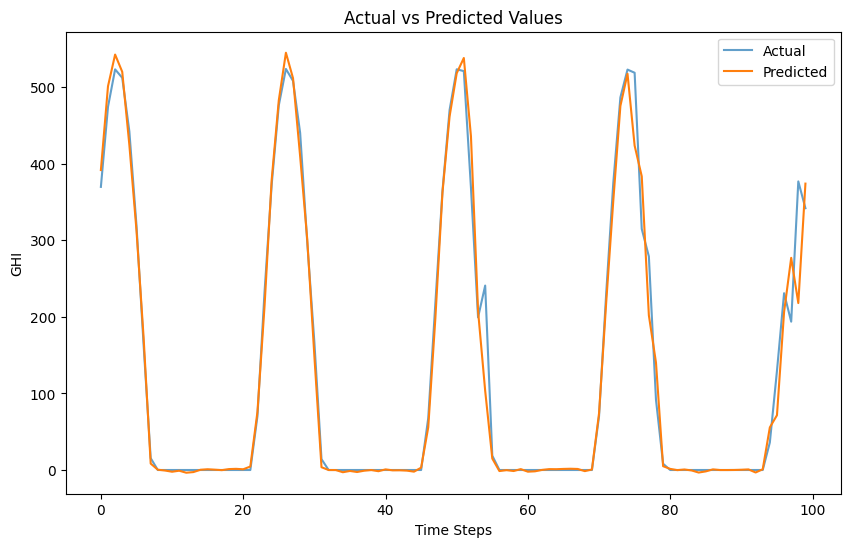

In [15]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(Y_test_unscaled[:100], label='Actual', alpha=0.7)  # First 100 samples
plt.plot(Y_pred_unscaled[:100], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('GHI')
plt.legend()
plt.show()

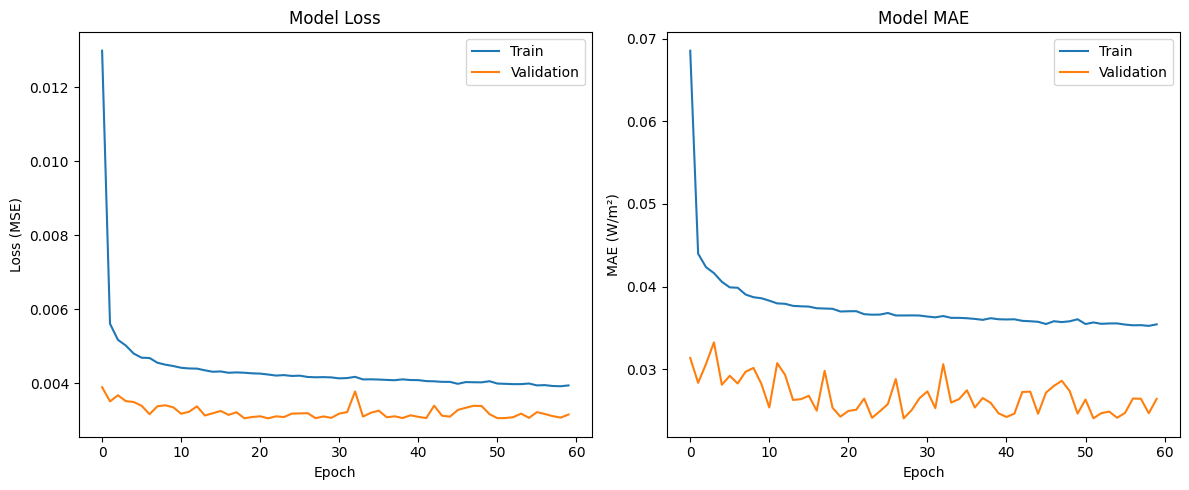

In [35]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title('Model MAE')
plt.ylabel('MAE (W/m²)')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
actor, critic, combined = create_actor_critic_models(input_shape)

actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_episodes = 10

for 
